## ***English to German Language Translator using a Sequence to Sequence (Seq2Seq) model***

* This Notebook demonstrates the implementation of an English to German language translator using a Sequence to Sequence (Seq2Seq) model. 

* The notebook is structured into several steps, starting with importing the required dependencies and preprocessing the text data. 

* It then proceeds to build and train the Seq2Seq model using Keras' Functional API, incorporating LSTM layers for improved translation accuracy. 

* The notebook also includes functions for evaluating the model's performance using the BLEU score and visualizing the training process.

##### **Referenced Materials**


* https://www.youtube.com/watch?v=L8HKweZIOmg&ab_channel=StatQuestwithJoshStarmer
* https://keras.io/guides/functional_api/
* https://keras.io/api/keras_nlp/tokenizers/word_piece_tokenizer/#wordpiecetokenizer-class
* https://medium.com/@chunduri11/understanding-lstm-plain-and-simple-96026b4468c6
* https://medium.com/analytics-vidhya/lstms-explained-a-complete-technically-accurate-conceptual-guide-with-keras-2a650327e8f2
* https://keras.io/api/callbacks/reduce_lr_on_plateau/
* https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b
* https://www.nltk.org/api/nltk.translate.bleu_score.html
* https://medium.com/analytics-vidhya/neural-machine-translation-using-simple-seq2seq-517b5ce1ae0f

_____

##### **STEP 1: Importing Required Dependencies**

In [4]:
# !pip install keras keras-preprocessing tensorflow nltk 

In [5]:
# !pip install --upgrade keras-nlp
# !pip install --upgrade keras

In [3]:
import string
from numpy import array
from keras.models import Model
from keras.layers import Dense, LSTM, Embedding, Dropout, Input, Bidirectional, concatenate
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import numpy as np
import keras_nlp
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
%matplotlib inline

_____

##### **STEP 2: Processing the text file and PreProcessing Texts**

* This function reads the text file and returns the content as a string

In [4]:
def read_txt_file(file_path):
    """
    Reads the content of a text file and returns it as a string.

    Args:
        file_path (str): The path to the text file to be read.

    Returns:
        str: The content of the text file.
    """
    
    #open the txt file as rt: read text mode
    txt_file = open(file=file_path, mode='rt', encoding='utf-8') 

    #read the content of the file
    text = txt_file.read()

    #close the file
    txt_file.close()

    return text

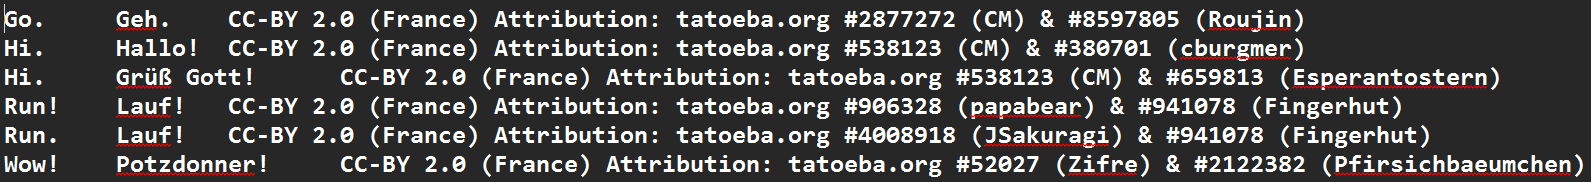

                                                -- First six lines of the text file --

* As shown in the figure above, the text file contains copyright attributions. They must be removed.
* This function processes the input text to extract sentence pairs where each pair consists of an English sentence and its corresponding German sentence. 
* NOTE: *The contents of every line are separated by a tab character.* 
* The function excludes any lines that do not contain at least one English and one German sentence.

In [5]:
def extract_sent_pairs(text):
    """
    Process the text to extract only English and German sentence pairs (exclude the copyright attributions)
    
    Args:
        text (str): The input text containing English and German sentence pairs and copyrights separated by tab characters.

    Returns:
        str: A string containing the extracted sentence pairs, with each pair separated by a newline character.
    """
    
    #initialise an empty list to store sentence pairs
    sent_pairs = []

    #split the text into lines
    lines = text.strip().split('\n')

    #split every line into english and german sentences 
    for line in lines:
        parts = line.split('\t') #split using tab as the delimeter

        if len(parts) >= 2: #ensure that every line atleast has one english and german letter
            english_part = parts[0].strip() #english sentence
            german_part = parts[1].strip() #german sentence
            sent_pairs.append(f"{english_part}\t{german_part}") #join english and german sentences separated by a tab

    return "\n".join(sent_pairs) #return the sentence pairs separated by a newline character as a string

* This function takes in the texts without the copyright attributions and returns an array of sentence pairs.
* For ex: 
    * sent_pairs_srt = "**Go.\tGeh.\nHi.\tHallo!\nRun!\tLauf!\nWow!\tDonnerwetter!**"
    
    * The function returns the array of sentence pairs as:
        
        sent_pairs_separated = **[["Go.", "Geh."],
                                  ["Hi.", "Hallo!"],
                                  ["Run!", "Lauf!"],
                                  ["Wow!", "Donnerwetter!"]]**


In [6]:
def to_lines_arr(sent_pairs_str):
    """
    Convert a string of sentence pairs into a numpy array of separated sentences.

    Args:
        sent_pairs_str (str): A string containing sentence pairs separated by newlines,
                              with each pair separated by a tab character.
                              
    Returns:
        numpy.ndarray: A 2D array where each row contains a pair of sentences.
    """
    #split the text to get sentence pairs 
    sent_pairs = sent_pairs_str.strip().split('\n') 

    #split the pairs to get each language part
    sent_pairs_separated = [pair.split('\t') for pair in sent_pairs]

    return array(sent_pairs_separated)

* This function performs the following preprocessing steps:
  
    1. Removes punctuation from both English and German sentences.
    2. Converts all characters in both English and German sentences to lowercase.

In [7]:
def preprocess_txt(eng_ger_arr):
    """
    Preprocesses an array of English and German sentence pairs.
    
    Args:
        eng_ger_arr (numpy.ndarray): A 2D numpy array where each row contains a pair of sentences 
                                     (English sentence at index 0 and German sentence at index 1).
                                     
    Returns:
        numpy.ndarray: The preprocessed array with punctuation removed and all characters in lowercase.
    """

    #1) Remove Punctuation
    for i in range(2):
        eng_ger_arr[:,i] = [sent.translate(str.maketrans('', '', string.punctuation)) for sent in eng_ger_arr[:,i]]
        
    #2) Convert to lowercase
    for i in range(len(eng_ger_arr)):
        eng_ger_arr[i,0] = eng_ger_arr[i,0].lower() #english
        eng_ger_arr[i,1] = eng_ger_arr[i,1].lower() #german

    return eng_ger_arr

* This function plots the length of the English and German sentences in the dataset.
* The resulting histogram is used to roughly understand about the distribution of the sentence lengths in the dataset.

In [8]:
def sent_lengths_hist(eng_ger_arr, n_bins):
    """
    Plots histograms of sentence lengths for English and German sentences.

    Args:
        eng_ger_arr (numpy.ndarray): A 2D array where the first column contains English sentences 
                                    and the second column contains German sentences.
        n_bins (int): The number of bins to use for the histograms.
    """

    #english sentences lengths (num of words)
    eng_len = [len(eng_sent.split()) for eng_sent in eng_ger_arr[:,0]]

    #german sentences lengths 
    ger_len = [len(ger_sent.split()) for ger_sent in eng_ger_arr[:,1]]

    #create subplots
    _, axes = plt.subplots(1, 2, figsize=(12,8))

    #histogram for english sentences
    axes[0].hist(
        x=eng_len,
        bins=n_bins,
        color='blue',
    )

    axes[0].set_title('English Sentence Lengths')
    axes[0].set_xlabel('Length of English Sentences')
    axes[0].set_ylabel('Number of English Sentences')

    #histogram for german sentences
    axes[1].hist(
        x=ger_len,
        bins=n_bins,
        color='red',
    )

    axes[1].set_title('German Sentence Lengths')
    axes[1].set_xlabel('Length of German Sentences')
    axes[1].set_ylabel('Number of German Sentences')

    #adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

* This function calcualtes the maximum lengths of the English and German sentences in the dataset.
* These maximum lengths are used to pad the sentences to a fixed length during the training process.

In [9]:
def max_length(sentences):
    """
    Calculates the maximum length of sentences (number of words) in a list.

    Args:
        sentences (list of str): A list of sentences.

    Returns:
        int: The maximum length of the sentences.
    """

    return max(len(sent.split()) for sent in sentences)

* This function adds the "start" and "end" special tokens to each sentence in the target language (German)

In [10]:
def add_special_tokens_to_target(eng_ger_arr):
    """
    Adds "start", "end" special tokens.

    Args:
        eng_ger_arr (numpy.ndarray): A 2D array where the first column contains English sentences 
                                    and the second column contains German sentences.

    Returns:
        numpy.ndarray: The modified array with special tokens added to the target sentences.
    """

    start_tok = "[start]" #start token
    end_tok = "[end]" #end token

    #add start and end tokens to the target sentences
    eng_ger_arr[:, 1] = [start_tok + " " + sent + " " + end_tok for sent in eng_ger_arr[:, 1]] 
    
    return eng_ger_arr

##### **STEP 2.1: Testing section**

This section tests the preprocessing functions to ensure that those functions are working as expected.

In [11]:
#read the text file
text = read_txt_file('assessment-final/deu-eng/deu.txt')

#extract sentence pairs
sent_pairs_str = extract_sent_pairs(text)

#convert the string to a numpy array
eng_ger_arr = to_lines_arr(sent_pairs_str)
print("\n First 5 sentence pairs: \n")
print(eng_ger_arr[:5])
print("-----------------------------------------------------------------------------------------------\n")

#preprocess the text
eng_ger_arr = preprocess_txt(eng_ger_arr)
print("\n First 5 sentence pairs after preprocessing: \n")
print(eng_ger_arr[:5])
print("-----------------------------------------------------------------------------------------------\n")


 First 5 sentence pairs: 

[['Go.' 'Geh.']
 ['Hi.' 'Hallo!']
 ['Hi.' 'Grüß Gott!']
 ['Run!' 'Lauf!']
 ['Run.' 'Lauf!']]
-----------------------------------------------------------------------------------------------


 First 5 sentence pairs after preprocessing: 

[['go' 'geh']
 ['hi' 'hallo']
 ['hi' 'grüß gott']
 ['run' 'lauf']
 ['run' 'lauf']]
-----------------------------------------------------------------------------------------------



In [12]:
#check the shape of the array storing English and German sentence pairs
eng_ger_arr.shape

(277891, 2)

In [13]:
#get the first 100,000 sentence pairs for computational cost reduction
eng_ger_arr = eng_ger_arr[:100000]

In [14]:
#add [start] and [end] tokens to the target (German) sequences
eng_ger_arr = add_special_tokens_to_target(eng_ger_arr)

In [15]:
#print out the maximum number of tokens in each language
eng_sents = eng_ger_arr[:,0]
ger_sents = eng_ger_arr[:,1]

print("Max length of English Sentences:",max_length(eng_sents))
print("Max length of German Sentences:",max_length(ger_sents))

Max length of English Sentences: 8
Max length of German Sentences: 19


In [16]:
#print 3 English sentences after all preprocessing steps
print(eng_ger_arr[5000:5003,0])

['stop yelling' 'stop yelling' 'stop please']


In [17]:
#print 3 German sentences after all preprocessing steps
print(eng_ger_arr[5000:5003,1])

['[start] hört auf zu schreien [end]'
 '[start] hören sie auf zu schreien [end]' '[start] anhalten bitte [end]']



* This function initializes a Tokenizer object, fits it on the provided sentences,
    and returns the tokenizer. 
* The tokenizer can then be used to convert text to sequences
    of integers, where each integer represents a word in the text.

In [18]:
def tokenize(sentences):
    """
    Tokenizes a list of sentences, with special token handling for target sequences.
    
    Args:
        sentences (list of str): A list of sentences to be tokenized.

    Returns:
        keras_nlp.tokenizers.WordPieceTokenizer: A WordPieceTokenizer object with vocabulary.
    """

    #split sentences into words and get unique vocabulary as a list
    vocab = list(set(" ".join(sentences).split()))

    #add additional "[unk]" and "[pad]" special tokens
    vocab = ["[pad]", "[unk]"] + vocab

    #initialize WordPieceTokenizer with vocabulary
    tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
        vocabulary=vocab,
        oov_token="[unk]",
        special_tokens = ["[pad]", "[unk]", "[start]", "[end]"],
        special_tokens_in_strings=True
    )

    return tokenizer

* This function takes in the English and German sentences and the tokenizer function and returns the tokenizer corresponding to each language and the vocabulary size of each language.
* These returned objects and values are used later for creating training , testing datasets and for building the model.

In [ ]:
def tokenize_eng_ger(eng_ger_arr, tokenize_func):
    """
    Tokenizes English and German sentences.

    Args:
        eng_ger_arr (numpy.ndarray): A 2D array where the first column contains English sentences 
                                     and the second column contains German sentences.
        tokenize_func (function): The function to use for tokenization.

    Returns:
        Tuple: A tuple containing the English and German tokenizers,
               English vocabulary size, and the German vocabulary size.
    """
    #tokenize English sentences (source) - no special tokens needed
    eng_tokenizer = tokenize_func(eng_ger_arr[:, 0])
    eng_vocab_size = len(eng_tokenizer.vocabulary)

    #tokenize German sentences (target) - with special tokens
    ger_tokenizer = tokenize_func(eng_ger_arr[:, 1])
    ger_vocab_size = len(ger_tokenizer.vocabulary)

    return eng_tokenizer, ger_tokenizer, eng_vocab_size, ger_vocab_size


##### **STEP 2.2: Testing section**

This section tests the tokenizer functions to ensure that those functions are working as expected.

In [20]:
#get the tokenizers and vocabulary sizes
e_tokenizer, g_tokenizer, e_voc_size, g_voc_size = tokenize_eng_ger(eng_ger_arr, tokenize)
print(e_voc_size,g_voc_size)

2024-11-04 11:31:13.424514: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


8991 15807


In [21]:
#assert the presence of special tokens in target vocabulary (German)
sp_tokens = ["[pad]", "[unk]", "[start]", "[end]"]

for token in sp_tokens: 
    print(f"{token} ID: ",g_tokenizer.token_to_id(token)) 

[pad] ID:  0
[unk] ID:  1
[start] ID:  9453
[end] ID:  9605


In [22]:
#assert the presence of special tokens in input/source vocabulary (English)
sp_tokens = ["[pad]", "[unk]"]

for token in sp_tokens: 
    print(f"{token} ID: ",e_tokenizer.token_to_id(token)) 

[pad] ID:  0
[unk] ID:  1


In [23]:
#convert an English sentence to a sequence of token IDs
print(e_tokenizer.tokenize("hello i am thiviru"))

tf.Tensor([6528 5574 3193    1], shape=(4,), dtype=int32)


In [24]:
#get the index of a token in the German vocabulary
g_tokenizer.token_to_id('liebe')

14809

In [25]:
#convert an English sentence to a sequence of token IDs
print(e_tokenizer.tokenize("This Notebook demonstrates the implementation of an English to German language translator using a Sequence to Sequence (Seq2Seq) model."

"* The notebook is structured into several steps, starting with importing the required dependencies and preprocessing the text data."

"* It then proceeds to build and train the Seq2Seq model using Keras' Functional API, incorporating LSTM layers for improved translation accuracy."))

tf.Tensor(
[   1    1    1 5558    1 6325 1082    1 3636    1 6266 3574 7000 5182
    1 3636    1    1    1    1 4979    1    1    1 6218 7426    1 1597
  941 1990    1 8735 3789    1 5558 2716    1 4793    1 5558 6003 1088
    1    1    1 3097    1 3636 3449 4793 8728 5558    1 4979 7000    1
    1    1    1    1    1    1    1 5609 2710 8265    1    1], shape=(68,), dtype=int32)


* This function takes in the specific langauge tokenizer and the sentences in that language and returns the sequences of integers corresponding to the words in the sentences. 
* The sequences are also padded to the maximum length of the sentences in the dataset.

In [26]:
def prep_seq(lang_tokenizer, lang_max_len, lang_sentences):
    """
    Prepares sequences for the given language by encoding sentences to integers and padding them.
    
    Args:
        lang_tokenizer (WordPieceTokenizer): The tokenizer used to encode the sentences.
        lang_max_len (int): The maximum length of the sequences after padding.
        lang_sentences (list of str): The sentences to be encoded and padded.

    Returns:
        numpy.ndarray: The encoded and padded sequences.
    """
    #tokenize sentences to integer sequences
    seq = lang_tokenizer.tokenize(lang_sentences)

    #pad sequences to the specified max length
    seq = pad_sequences(seq, maxlen=lang_max_len, padding='post', value=lang_tokenizer.token_to_id("[pad]"))
        
    return seq

##### **STEP 2.3: Testing section**

This section tests the sequence padding functions to ensure that those functions are working as expected and also tests German sequences to see if they have the correct structure of start and end tokens.

In [27]:
#recheck max lengths to verify shapes
e_max_len = max_length(eng_ger_arr[:100000,0])
g_max_len = max_length(eng_ger_arr[:100000,1])

print(e_max_len, g_max_len)

8 19


In [28]:
#prepare sequences for English sentences
e_seq = prep_seq(e_tokenizer, e_max_len, eng_ger_arr[:,0])

In [29]:
#prepare sequences for German sentences
g_seq = prep_seq(g_tokenizer, g_max_len, eng_ger_arr[:,1])

In [30]:
#check the shape of the English sequences
e_seq.shape

(100000, 8)

In [31]:
#check the shape of the German sequences
g_seq.shape

(100000, 19)

In [32]:
#check 5 English sequences after encoding and padding
e_seq[5000:5005]

array([[2515, 8114,    0,    0,    0,    0,    0,    0],
       [2515, 8114,    0,    0,    0,    0,    0,    0],
       [2515, 1102,    0,    0,    0,    0,    0,    0],
       [3882, 3624,    0,    0,    0,    0,    0,    0],
       [3882, 3624,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [33]:
#detokenize the 5 English sequences to verify the encoding
e_tokenizer.detokenize(e_seq[5000:5005])

['stop yelling [pad] [pad] [pad] [pad] [pad] [pad]',
 'stop yelling [pad] [pad] [pad] [pad] [pad] [pad]',
 'stop please [pad] [pad] [pad] [pad] [pad] [pad]',
 'sweet dreams [pad] [pad] [pad] [pad] [pad] [pad]',
 'sweet dreams [pad] [pad] [pad] [pad] [pad] [pad]']

Visually assert random sequences to see if start and end tokens are there in target sequences

In [34]:
for i in range(10):
    rand = np.random.randint(100000)
    print(f"Seq {rand}: ",g_tokenizer.detokenize(g_seq[rand]))

Seq 52194:  [start] alpträume sind angsteinflößend [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]
Seq 97021:  [start] warum hat sie mich unterbrochen [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]
Seq 11388:  [start] tom ist geizig [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]
Seq 17699:  [start] das geschäft läuft nicht gut [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]
Seq 34171:  [start] ich bin nicht glücklich [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]
Seq 79648:  [start] ich hätte tom gewinnen lassen sollen [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]
Seq 78578:  [start] ich kann das auch nicht [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]
Seq 28701:  [start] tom hat so seine launen [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] 

Assert if all target sequences have start and end tokens

In [35]:
#check if all target(German Sequences) have a start and end token
for i, seq in enumerate(g_seq):
    start_tok = g_tokenizer.token_to_id("[start]")
    end_tok = g_tokenizer.token_to_id("[end]")

    if (start_tok not in seq) and (end_tok not in seq):
        print(f"Fail: Sequence at index {i} does not have a start or an end token.")

____

##### **STEP 3: Training the Model**

* This function splits the prepared sequences of English and German sentences into training and testing datasets.

In [36]:
def train_test_data(eng_ger_arr, eng_max_len, ger_max_len, eng_tokenizer, ger_tokenizer, prep_seq, test_fraction=0.2):
    """
    Splits the given English-German sentence pairs into training and testing sets, and prepares the data for model training.

    Args:
        eng_ger_arr (numpy.ndarray): Array of English-German sentence pairs.
        eng_max_len (int): Maximum length of English sentences.
        ger_max_len (int): Maximum length of German sentences.
        eng_tokenizer (Tokenizer): Tokenizer for English sentences.
        ger_tokenizer (Tokenizer): Tokenizer for German sentences.
        prep_seq (function): Function to preprocess sequences.
        test_fraction (float, optional): Fraction of the data to be used for testing. Defaults to 0.2.
        
    Returns:
        tuple: A tuple containing:
            - trainX (numpy.ndarray): Preprocessed English training sentences.
            - trainY (numpy.ndarray): Preprocessed German training sentences.
            - testX (numpy.ndarray): Preprocessed English testing sentences.
            - testY (numpy.ndarray): Preprocessed German testing sentences.
    """
    #split the data into training and testing sets
    train_pairs, test_pairs = train_test_split(eng_ger_arr, test_size=test_fraction, random_state=42)

    #prepare the training and testing data
    #English sentences : Inputs (X), German sentences : Outputs (y)

    #Training data
    trainX = prep_seq(eng_tokenizer, eng_max_len, train_pairs[:,0])
    trainY = prep_seq(ger_tokenizer, ger_max_len, train_pairs[:,1])

    #Testing data
    testX = prep_seq(eng_tokenizer, eng_max_len, test_pairs[:,0])
    testY = prep_seq(ger_tokenizer, ger_max_len, test_pairs[:,1])

    return trainX, trainY, testX, testY

##### **STEP 3.1: Testing section**

This section tests the train-test split function to ensure that it is working as expected.

In [37]:
#split the data into training and testing sets
trainX, trainY, testX, testY = train_test_data(eng_ger_arr, e_max_len, g_max_len, e_tokenizer, g_tokenizer, prep_seq, test_fraction=0.2)

In [38]:
#check the shape of the training and testing data
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(80000, 8) (20000, 8) (80000, 19) (20000, 19)


In [39]:
#check 3 English training sequences
e_tokenizer.detokenize(trainX[2:5])

['tom has two options [pad] [pad] [pad] [pad]',
 'i feel terrific [pad] [pad] [pad] [pad] [pad]',
 'she burned her left hand [pad] [pad] [pad]']

In [40]:
#check 3 corresponding German training sequences
g_tokenizer.detokenize(trainY[2:5])

['[start] tom hat zwei optionen [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]',
 '[start] ich fühle mich großartig [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]',
 '[start] sie verbrannte sich die linke hand [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]']

In [41]:
#check 3 English testing sequences
e_tokenizer.detokenize(testX[2:5])

['im not like you [pad] [pad] [pad] [pad]',
 'are you an archeologist [pad] [pad] [pad] [pad]',
 'switch the headlights on [pad] [pad] [pad] [pad]']

In [42]:
#check 3 corresponding German testing sequences
g_tokenizer.detokenize(testY[2:5])

['[start] ich bin nicht wie du [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]',
 '[start] bist du archäologe [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]',
 '[start] schalten sie die scheinwerfer an [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]']

* This function is used to shift the target sequences by one timestep to be used as input for the decoder. 
* For example, if a target sentence in trainY is ["start", "Ich", "bin", "glücklich", "end"], the trainY_input will be ["start", "Ich", "bin", "glücklich"] (last token dropped), and trainY_output will be ["Ich", "bin", "glücklich", "end"] (first token dropped).

In [ ]:
def prep_decoder_data(trainY):
    """
    Prepares decoder input and target output for training, assuming trainY already includes <start> and <end> tokens.
    
    Args:
        trainY (numpy.ndarray): Preprocessed target sequences with <start> and <end> tokens.
    
    Returns:
        trainY_input (numpy.ndarray): Decoder input sequences (shifted by one timestep).
        trainY_output (numpy.ndarray): Target output sequences (shifted by one timestep, with <start> removed).
    """

    #create trainY_input by shifting trainY by 1 timestep to the right
    trainY_input = trainY[:, :-1]  #remove the last token (end) for decoder input

    #create trainY_output by removing the first token (start) from trainY
    trainY_output = trainY[:, 1:]  #decoder target should predict from second token onward

    return trainY_input, trainY_output


##### **STEP 3.2: Testing section**

This section tests the shifting function to ensure that it is working as expected.

In [44]:
#prepare decoder input and output data
trainY_input, trainY_output = prep_decoder_data(trainY, g_tokenizer)

In [45]:
#check the shape of the decoder input and output data
print(trainY_input.shape, trainY_output.shape)

(80000, 18) (80000, 18)


In [46]:
#check 3 German decoder inputs after shifting by one timestep to the right
g_tokenizer.detokenize(trainY_input[2:5])

['[start] tom hat zwei optionen [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]',
 '[start] ich fühle mich großartig [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]',
 '[start] sie verbrannte sich die linke hand [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]']

In [47]:
#check 3 German decoder outputs after removing the first token 
g_tokenizer.detokenize(trainY_output[2:5])

['tom hat zwei optionen [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]',
 'ich fühle mich großartig [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]',
 'sie verbrannte sich die linke hand [end] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad] [pad]']

* This function builds the Seq2Seq model.

**1) Encoder layers:**

* The encoder takes the input sequence and compresses it into a context vector (forward, backward hidden states and cell states) which summarises the input information.
    
* The encoder consists of an embedding layer and an LSTM layer.
  
    * *a) Embedding layer:*

        * Maps each word in the input sequence to a high-dimensional space of size (embedding_size).

    * *b) LSTM layer (Bidirectional):*

        * Processes the sequence of word embeddings and outputs forward and backward hidden states, cell states after reading the entire sequence.
        * These states are concatenated to form the context vector.
        * The Bidirectional LSTM layer is used to capture the context from both directions.
        * The LSTM layer is used to learn the sequential patterns in the input sequence.
        * The hidden states and cell states from the last timestep are used as the initial state for the decoder.



**2) Decoder layers:**

* The decoder takes in the concatenated hidden and cell states and generates the output sequence.
    
* The decoder consists of an Embedding layer, LSTM layers, Dropout layer, and a Dense layer.

    * *a) Embedding layer:*

        * Maps each word in the output sequence to a high-dimensional space of size (embedding_size).

    * *b) LSTM layer 1:*

        * Processes the sequence of word embeddings and outputs hidden states, cell states after reading the entire sequence.

    * *c) LSTM layer 2:*

        * This layer is added to increase model depth and learn more complex relationships.
        * This layer takes in the hidden and cell states from the previous LSTM layer and outputs hidden states, cell states, and the LSTM output after reading the entire sequence.

    * *d) Dropout layer 1:*

        * Randomly drops the defined percentage of the neurons during training to help prevent overfitting.

    * *e) Bidirectional LSTM layer:*

        * Processes the sequence of word embeddings and gives the LSTM output after reading the entire sequence.
        * The Bidirectional LSTM layer is used to capture the context from both directions and capture more hidden information in data.

    * *f) Dropout layer 2:*
        * Randomly drops the defined percentage of the neurons during training to help prevent overfitting.

    * *g) Dense layer:*

        * A fully connected layer that generates a probability distribution over the target vocabulary for each timestep.
        * The word with the highest probability is chosen as the output word for that timestep.

**NOTE:** The keras *Functional API* is used here to build the model instead of the Sequential API due to; 
* Its flexibility to handle multiple input layers separately 
* Inability  of the Sequential API to handle multiple embedding layers

In [48]:
def build_model(input_vocab_size, target_vocab_size, input_timesteps, lstm_units, embedding_size):
    """
    Builds and returns a sequence-to-sequence model using LSTM layers.

    Args:
        input_vocab_size (int): Size of the input vocabulary.
        target_vocab_size (int): Size of the target vocabulary.
        input_timesteps (int): Number of timesteps in the input sequences.
        lstm_units (int): Number of units in the LSTM layers.
        embedding_size (int): Dimension of the embedding space.

    Returns:
        keras.models.Sequential: The constructed Keras Sequential model.
    """

    # 1) ----ENCODER----

    #Encoder Input 
    encoder_input = Input(
        shape=(input_timesteps,), 
        name='ENCODER_INPUT_LAYER'
    )

    #Encoder Embedding Layer
    encoder_embedding = Embedding(
        input_vocab_size, 
        embedding_size,
        mask_zero=True, 
        name='ENCODER_EMBEDDING'
    )(encoder_input)

    #Bidirectional LSTM layer (return hidden and cell states)
    encoder_lstm = Bidirectional(
        LSTM(lstm_units, return_state=True),
        name='ENCODER_BIDIRECTIONAL_LSTM'
    )(encoder_embedding)

    #unpack the encoder output and states
    _, fwd_hidden, fwd_cell, bwd_hidden, bwd_cell = encoder_lstm

    #concatenate the states
    hidden_state = concatenate([fwd_hidden, bwd_hidden])
    cell_state = concatenate([fwd_cell, bwd_cell])

    ##############################################################

    # 2) ----DECODER----

    #Decoder Input
    decoder_input = Input(
        shape=(None,),
        name='DECODER_INPUT'
    )
        
    #Decoder Embedding Layer
    decoder_embedding = Embedding(
        target_vocab_size,
        embedding_size,
        mask_zero=True,
        name='DECODER_EMBEDDING'
    )(decoder_input)

    #LSTM layer 1
    decoder_lstm_1 = LSTM(
        lstm_units*2,
        return_sequences=True,
        return_state=True, 
        name='DECODER_LSTM_1', 
    )(decoder_embedding, initial_state=[hidden_state, cell_state])

    decoder_lstm_1_output, lstm1_h, lstm1_c = decoder_lstm_1

    #LSTM layer 2
    decoder_lstm_2 = LSTM(
        lstm_units*2, 
        return_sequences=True, 
        return_state=True, 
        name='DECODER_LSTM_2'
    )(decoder_lstm_1_output, initial_state=[lstm1_h, lstm1_c])

    decoder_lstm_2_output, state_h2, state_c2 = decoder_lstm_2

    #Dropout layer 1 
    dropout_1 = Dropout(
        rate=0.5, 
        name='DROPOUT_1'
    )(decoder_lstm_2_output)

    #Bidirectional LSTM layer
    decoder_bidir_lstm = Bidirectional(
        LSTM(lstm_units , return_sequences=True),
        name='DECODER_BIDIRECTIONAL_LSTM'
    )(dropout_1)

    #Dropout layer 2
    dropout_2 = Dropout(
        rate=0.5, 
        name='DROPOUT_2'
    )(decoder_bidir_lstm)

    #Output
    decoder_output = Dense(
        target_vocab_size, 
        activation='softmax',
        name='DECODER_OUTPUT'
    )(dropout_2)

    #Define the complete Encoder-Decoder model 
    model = Model([encoder_input, decoder_input], decoder_output)

    #Print model summary
    print(model.summary())

    return model

* This function defines the optimizer, loss function, and metric for the model and compiles the model.
* The model is trained on the training dataset and the loss and accuracy are calculated on the validation dataset.

***Teacher Forcing Method***

* The model is trained by using the ground truth sequence as the decoder input, so the decoder always gets the ***correct word*** from the previous timestep (Not the ***predicted word*** from the previous timestep).

***NOTE:*** This method only applies during the training phase. During inference, since no ground truths are available, the predicted word from the previous timestep is used as the input for the next timestep as usual.

***Learning Rate Scheduler (ReduceLROnPlateau):***

* It keeps track of the validation loss and reduces the learning rate by a factor of 0.8 if the validation loss does not decrease for 1 epoch.

In [ ]:
def train_model(eng_vocab_size, ger_vocab_size, eng_length, trainX, trainY_input, trainY_output, epochs, batch_size, build_model, lstm_units=128, embedding_size=200):
    """
    Trains a sequence-to-sequence model for language translation.

    Args:
        eng_vocab_size (int): Size of the English vocabulary.
        ger_vocab_size (int): Size of the German vocabulary.
        eng_length (int): Maximum ength of the English sequences.
        trainX (numpy.ndarray): Input data for training (English sequences).
        trainY_input (numpy.ndarray): Input data for teacher forced training.
        trainY_output (numpy.ndarray): Target data for teacher forced training.
        trainY (numpy.ndarray): Target data for training (German sequences).
        epochs (int): Number of epochs to train the model.
        batch_size (int): Size of the batches for training.
        build_model (function): Function to build the model architecture.
        lstm_units (int, optional): Number of LSTM units per LSTM layer. Defaults to 128.
        embedding_size (int, optional): Size of the embedding layer. Defaults to 200.

    Returns:
        history (History): A History object containing the training history.
    """
    
    optimizer = optimizers.Adam(learning_rate=0.001)
    model = build_model(eng_vocab_size, ger_vocab_size, eng_length, lstm_units, embedding_size)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

    #checkpoint
    checkpoint_filename = 'model.h1.10-10-24.keras'
    checkpoint = ModelCheckpoint(checkpoint_filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    #learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=1, verbose=1)

    #train model
    history = model.fit(
        [trainX, trainY_input], 
        trainY_output,
        epochs=epochs, 
        batch_size=batch_size, 
        validation_split = 0.3,
        callbacks=[checkpoint, lr_scheduler], 
        verbose=2
    )

    #return the training history object
    return history

* This function plots the training and validation loss and accuracy of the model.
* The plots are used to understand how well the model is learning the patterns in the data.

In [50]:
def plot_loss(history):
    """
    Plots the training and validation loss from the training history.

    Args:
        history (History): The training history of the model.
    """

    #Loss plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

____

##### **STEP 4: Evaluating the model**

**Brief summary about the Evaluation section:**

* Initially the trained model's layers are extrated to create a new model for the purpose of inference. 
* A new model is created because the trained model has teacher forcing enabled which is not required during inference.
* The new model is used to predict the German translation of the English sentences in the test dataset.
* The predicted German sentences are then evaluated using the ***BLEU score***, which is a metric used to evaluate the quality of machine-translated text.
* The BLEU score ranges from 0 to 1, with 1 indicating a perfect match between the predicted and reference sentences.

----

* The function below encodes the input sequence (English sentence) using the encoder part of the trained model and returns its context vector. 
* It uses the decoder part of the model to decode the context vector received from the encoder part. 
* It generates a target sequence word by word.
* Finally predicts the German translation of the English sentences in the test dataset 
* NOTE: The difference here is that the input to the decoder at each timestep is the ***Predicted word*** at the previous timestep, not the ***Correct word***.

In [51]:
def create_inference_models(model, lstm_units=128):
    """
    Creates separate encoder and decoder models for inference.
    
    Args:
        model (tf.keras.Model): The trained sequence-to-sequence model.
        lstm_units (int, optional): Number of LSTM units in each layer. Defaults to 128. (Check the model architecture initialisation for the exact number of units)

    Returns:
        tuple: A tuple containing the encoder model and the decoder model for inference.
        - encoder_model (tf.keras.Model): The encoder model for inference.
        - decoder_model (tf.keras.Model): The decoder model for inference.
    """

    #get encoder inputs directly from model's input
    encoder_inputs = model.input[0]  #first input tensor
    
    #extract encoder states from the trained model's layer
    _, fwd_state_h, fwd_state_c, bwd_state_h, bwd_state_c = model.layers[3].output  

    #concatenate forward and backward states for the decoder's initial state
    encoder_hidden_state = concatenate([fwd_state_h, bwd_state_h], axis=-1)
    encoder_cell_state = concatenate([fwd_state_c, bwd_state_c], axis=-1)
    
    #create encoder model
    encoder_model = Model(
        inputs=encoder_inputs,
        outputs=[
            [encoder_hidden_state, encoder_cell_state]
        ]
    )

    ##########################################################################################

    #create decoder state inputs for inference
    decoder_state_h_input = Input(shape=(lstm_units*2,), name='decoder_state_h') #decoder input hidden state
    decoder_state_c_input = Input(shape=(lstm_units*2,), name='decoder_state_c') #decoder input cell state
    decoder_states_inputs = [decoder_state_h_input, decoder_state_c_input]

    #get decoder inputs directly from model's input
    decoder_inputs = model.input[1]
    
    #get decoder embedding layer
    decoder_embedding = model.layers[4](decoder_inputs)

    #get decoder LSTM layer 1
    decoder_lstm1 = model.layers[7]

    #get decoder states and outputs
    decoder_lstm1_outputs, state_h1, state_c1 = decoder_lstm1(
        decoder_embedding, 
        initial_state=decoder_states_inputs
    )

    #get decoder LSTM layer 2
    decoder_lstm2 = model.layers[8]

    #get decoder states and outputs
    decoder_lstm2_outputs, state_h2, state_c2 = decoder_lstm2(
        decoder_lstm1_outputs, 
        initial_state=[state_h1, state_c1]
    )

    decoder_dense = model.layers[12]
    decoder_outputs = decoder_dense(decoder_lstm2_outputs)
    
    #create decoder model
    decoder_model = Model(
        inputs=[decoder_inputs] + decoder_states_inputs,
        outputs=[decoder_outputs] + [state_h2, state_c2]
    )
    
    #return the encoder and decoder models for inference
    return encoder_model, decoder_model

* This function translates the English sentences in the test dataset to German using the trained model and returns the translated sentences.

In [52]:
def translate_sequence(encoder_model, decoder_model, input_seq, target_tokenizer, max_len):
    """
    Translates a single sequence using the provided encoder and decoder models.

    Args:
        encoder_model (keras.Model): The encoder model used to encode the input sequence.
        decoder_model (keras.Model): The decoder model used to generate the output sequence.
        input_seq (numpy.ndarray): The input sequence to be translated.
        target_tokenizer (Tokenizer): The tokenizer used for the target language.
        max_len (int): The maximum length the translated sequence can have.
        
    Returns:
        str: The translated sequence as a single string.
    """
    
    #ensure input sequence is properly shaped
    if len(input_seq.shape) == 1:
        input_seq = np.expand_dims(input_seq, axis=0) #add a batch dimension
    
    #get encoder states
    states = encoder_model.predict(input_seq, verbose=0)
    
    #extract encoder states for decoder
    hidden_state, cell_state = states[0], states[1]
    states_value = [hidden_state, cell_state]
    
    #initialize target sequence with the start token
    target_seq = np.zeros((1, 1))
    start_token_idx = target_tokenizer.token_to_id("[start]")
    if start_token_idx is not None:
        target_seq[0, 0] = start_token_idx
    
    #initialize output sentence
    output_sentence = []
    end_token_idx = target_tokenizer.token_to_id("[end]")
    
    #generate the sentence word by word
    while True:
        #get the decoder output and states
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value,
            verbose=0
        )
        
        #get the predicted token index and corresponding word
        pred_token_idx = np.argmax(output_tokens[0, -1, :])
        pred_word = target_tokenizer.id_to_token(pred_token_idx)

        # #print the predicted word (for debugging)
        # print(f"\n\tword - {pred_word}, idx - {pred_token_idx}")

        #append word if valid
        if pred_word:
            output_sentence.append(pred_word)

        #check termination conditions
        if (pred_word == "[end]" or pred_token_idx == end_token_idx or len(output_sentence) >= max_len):
            # print("\nEnd of sentence")
            break
        
        #update target sequence with the predicted token
        target_seq[0, 0] = pred_token_idx
        
        #update states for the next prediction
        states_value = [h, c]
    
    #return the generated sentence as a single string
    return ' '.join(output_sentence)


* This function encapsulates the inference process using the 2 functions defined above.

In [53]:
def pred_test(model, test_sequences, target_tokenizer, target_max_len):
    """
    Make predictions for test sequences.

    Args:
        model (keras.Model): The trained sequence-to-sequence model.
        test_sequences (list): List of input sequences to be translated.
        target_tokenizer (keras.preprocessing.text.Tokenizer): Tokenizer for the target language.
        target_max_len (int): Maximum length of the target sequences.
        
    Returns:
        list: List of predicted sentences for each input sequence.
    """
    
    #create inference models
    encoder_model, decoder_model = create_inference_models(model)
    
    #initialize an empty list to store predicted sentences
    predicted_sentences = []
    
    #translate each test sequence
    for input_seq in test_sequences:
        predicted_seq = translate_sequence(
            encoder_model,
            decoder_model,
            array(input_seq),
            target_tokenizer,
            target_max_len
        )
        predicted_sentences.append(predicted_seq)
    
    return predicted_sentences

* This function converts the integer encoded sequences in the test Dataset and returns them in human readable form.

* These output sentences list is used as the list of references when calculating the BLEU metric. 

**NOTE:**

* In WordPiece tokenization (used in models like BERT and supported by KerasNLP), subwords are often prefixed with ## to indicate that they’re continuations of a word. 

* For instance: The word "playing" might be split into ["play", "##ing"].

* When decoded, you’d see "play ##ing", which isn’t the desired final form.
  
* Using .replace(" ##", "") removes the ## and joins subwords back into the original word, converting "play ##ing" into "playing". 
  
* This makes the reconstructed sentence more readable and closer to natural language.

In [54]:
def input_sentences(test_data, input_tokenizer):
    """
    Converts sequences of integers back to sentences using KerasNLP's WordPieceTokenizer.
    
    Args:
        test_data (array-like): Array of integer sequences.
        input_tokenizer (WordPieceTokenizer): The tokenizer used for the input language.
        
    Returns:
        list: List of reconstructed sentences.
    """
    inputs = []  #initialize list for sentences

    for seq in test_data:  #iterate over each sequence
        sentence = []  #initialize list for words
        
        for idx in seq:  #iterate over each index
            if idx != 0:  #skip padding tokens 
                word = input_tokenizer.id_to_token(idx)  #convert index to word
                if word is not None:  #only append if word exists
                    sentence.append(word)
        
        #join words into sentence, handling special tokens if needed
        sentence_str = ' '.join(sentence).replace(" ##", "")  #join and handle WordPiece subwords
        inputs.append(sentence_str)  #add sentence to list

    return inputs

* This function takes in the true input sentences and the predicted sentences and outputs the bleu score.
* BLEU expects a list of references for each sentence, so the reference sentences are nested to create a list of lists

In [55]:
def eval_bleu(input_test_sentences, predicted_sentences):
    """
    Evaluate the BLEU score for a set of predicted sentences against the reference sentences.

    Args:
        input_test_sentences (list of str): The reference sentences.
        predicted_sentences (list of str): The sentences generated by the model.

    Returns:
        None: Prints the BLEU score for the corpus.
    """
    
    #prepare the reference format required for BLEU (list of lists)
    references_sentences = [[ref] for ref in input_test_sentences]

    #smoothing for better BLEU score results, especially for short sentences
    smoothing_fn = SmoothingFunction().method1 

    #calculate the BLEU score for the corpus
    bleu_score = corpus_bleu(references_sentences, predicted_sentences, smoothing_function=smoothing_fn)
    print(f'Corpus BLEU score: {bleu_score:.4f}')

_____

##### **STEP 5: Running the entire Machine Translation process**

* The cell below does the following functions:
    1) Reads the text file.
    2) Extracts sentence pairs.
    3) Converts the sentence strings into a numpy array.
    4) Preprocess the sentences.

* Additionally it prints out the first 5 sentence pairs before preprocessing and after preprocessing, to verify that the steps have been applied properly.

In [56]:
#read the text file
text = read_txt_file('assessment-final/deu-eng/deu.txt')

#extract sentence pairs
sent_pairs_str = extract_sent_pairs(text)

#convert the string to a numpy array
eng_ger_arr = to_lines_arr(sent_pairs_str)
print("\n First 5 sentence pairs: \n")
print(eng_ger_arr[:5])
print("-----------------------------------------------------------------------------------------------\n")

#preprocess the text
eng_ger_arr = preprocess_txt(eng_ger_arr)
print("\n First 5 sentence pairs after preprocessing: \n")
print(eng_ger_arr[:5])
print("-----------------------------------------------------------------------------------------------\n")


 First 5 sentence pairs: 

[['Go.' 'Geh.']
 ['Hi.' 'Hallo!']
 ['Hi.' 'Grüß Gott!']
 ['Run!' 'Lauf!']
 ['Run.' 'Lauf!']]
-----------------------------------------------------------------------------------------------


 First 5 sentence pairs after preprocessing: 

[['go' 'geh']
 ['hi' 'hallo']
 ['hi' 'grüß gott']
 ['run' 'lauf']
 ['run' 'lauf']]
-----------------------------------------------------------------------------------------------



* The cell below perform the following functions:
    1) Extracts only the first 100000 sentence pairs to limit computations.
    2) Plot a histogram per language, to understand about the number of words in sentences.
    3) Adding special tokens ('start' and 'end') to the target sentences.
    4) Tokenize sentences in both languages.
    5) Split the data into training and testing sets.
    6) Prepare input formats for the decoder (Suitable for teacher forcing technique)

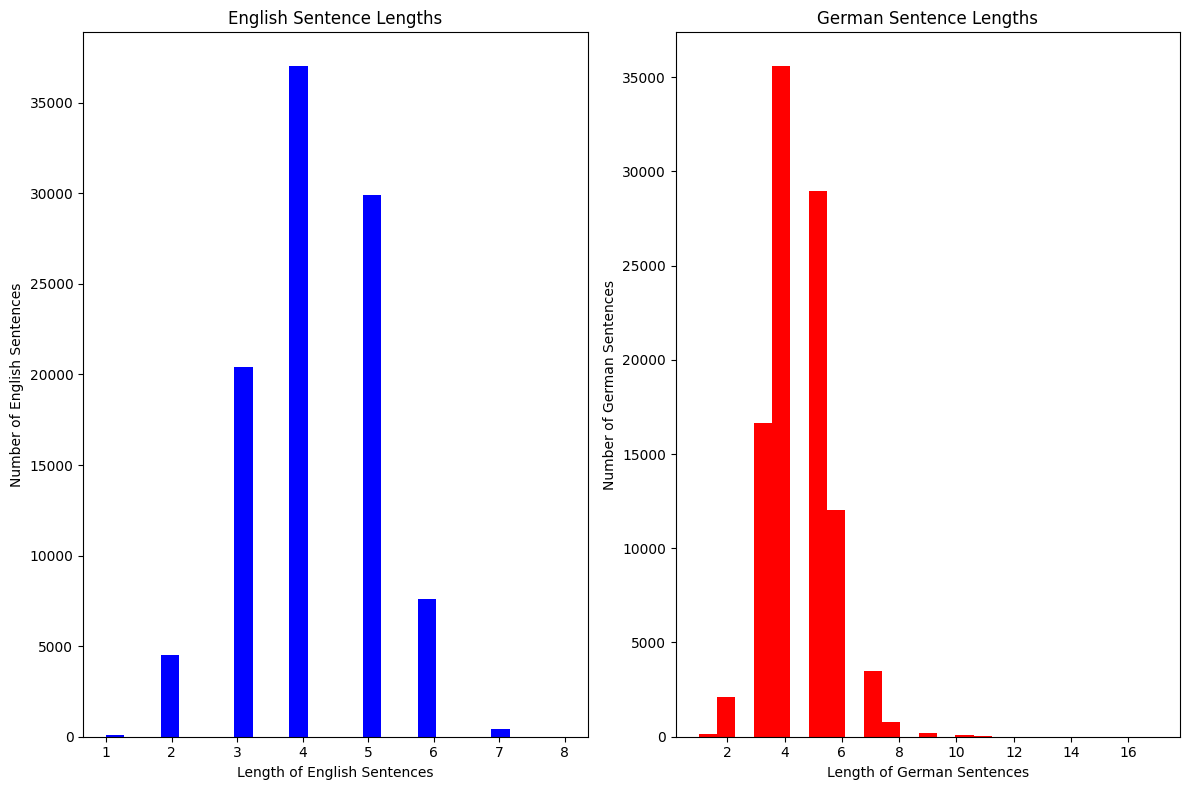

In [57]:
#get only the first 100000 sentence pairs
eng_ger_arr = eng_ger_arr[:100000,:]

#plot histograms of sentence lengths
sent_lengths_hist(eng_ger_arr, 25)

#get the maximum length of sentences
eng_max_len = max_length(eng_ger_arr[:,0])
ger_max_len = max_length(eng_ger_arr[:,1])

#adding special tokens (start and end) to the target sequences
eng_ger_arr = add_special_tokens_to_target(eng_ger_arr)

#tokenize the sentences
eng_tokenizer, ger_tokenizer, eng_vocab_size, ger_vocab_size = tokenize_eng_ger(eng_ger_arr, tokenize)

#split the data into training and testing sets
trainX, trainY, testX, testY = train_test_data(eng_ger_arr, eng_max_len, ger_max_len, eng_tokenizer, ger_tokenizer, prep_seq)

#prepare the decoder input sequences for training
trainY_input, trainY_output = prep_decoder_data(trainY, ger_tokenizer)

* This cell trains the Seq2Seq model for the specified number of epochs and batch size.
* Finally, plots the loss curve comparing the loss of training and validation data. 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ENCODER_INPUT_LAYER │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ENCODER_EMBEDDING   │ (None, 8, 200)    │  1,798,200 │ ENCODER_INPUT_LA… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 8)         │          0 │ ENCODER_INPUT_LA… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DECODER_INPUT       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ENCODER_BIDIRECTIO… │ [(None, 256),     │    336,896 │ ENCODER_EMBEDDIN… │
│ (Bidirectional)     │ (None, 128),      │            │ not_equal[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DECODER_EMBEDDING   │ (None, None, 200) │  3,161,400 │ DECODER_INPUT[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ ENCODER_BIDIRECT… │
│ (Concatenate)       │                   │            │ ENCODER_BIDIRECT… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ ENCODER_BIDIRECT… │
│ (Concatenate)       │                   │            │ ENCODER_BIDIRECT… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DECODER_LSTM_1      │ [(None, None,     │    467,968 │ DECODER_EMBEDDIN… │
│ (LSTM)              │ 256), (None,      │            │ concatenate[0][0… │
│                     │ 256), (None,      │            │ concatenate_1[0]… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DECODER_LSTM_2      │ [(None, None,     │    525,312 │ DECODER_LSTM_1[0… │
│ (LSTM)              │ 256), (None,      │            │ DECODER_LSTM_1[0… │
│                     │ 256), (None,      │            │ DECODER_LSTM_1[0… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DROPOUT_1 (Dropout) │ (None, None, 256) │          0 │ DECODER_LSTM_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, None)      │          0 │ DECODER_INPUT[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DECODER_BIDIRECTIO… │ (None, None, 256) │    394,240 │ DROPOUT_1[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DROPOUT_2 (Dropout) │ (None, None, 256) │          0 │ DECODER_BIDIRECT… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DECODER_OUTPUT      │ (None, None,      │  4,062,399 │ DROPOUT_2[0][0]   │
│ (Dense)             │ 15807)            │            │                 

 Total params: 10,746,415 (40.99 MB)

 Trainable params: 10,746,415 (40.99 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ENCODER_INPUT_LAYER', 'DECODER_INPUT']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2024-11-04 11:32:15.925220: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.



Epoch 1: val_loss improved from inf to 2.11981, saving model to model.h1.10-10-24.keras
3500/3500 - 416s - 119ms/step - loss: 3.2686 - val_loss: 2.1198 - learning_rate: 0.0010
Epoch 2/20

Epoch 2: val_loss improved from 2.11981 to 1.53376, saving model to model.h1.10-10-24.keras
3500/3500 - 410s - 117ms/step - loss: 1.9105 - val_loss: 1.5338 - learning_rate: 0.0010
Epoch 3/20

Epoch 3: val_loss improved from 1.53376 to 1.23955, saving model to model.h1.10-10-24.keras
3500/3500 - 436s - 125ms/step - loss: 1.4582 - val_loss: 1.2395 - learning_rate: 0.0010
Epoch 4/20

Epoch 4: val_loss improved from 1.23955 to 1.06840, saving model to model.h1.10-10-24.keras
3500/3500 - 443s - 126ms/step - loss: 1.1907 - val_loss: 1.0684 - learning_rate: 0.0010
Epoch 5/20

Epoch 5: val_loss improved from 1.06840 to 0.95144, saving model to model.h1.10-10-24.keras
3500/3500 - 429s - 123ms/step - loss: 1.0107 - val_loss: 0.9514 - learning_rate: 0.0010
Epoch 6/20

Epoch 6: val_loss improved from 0.95144 to 

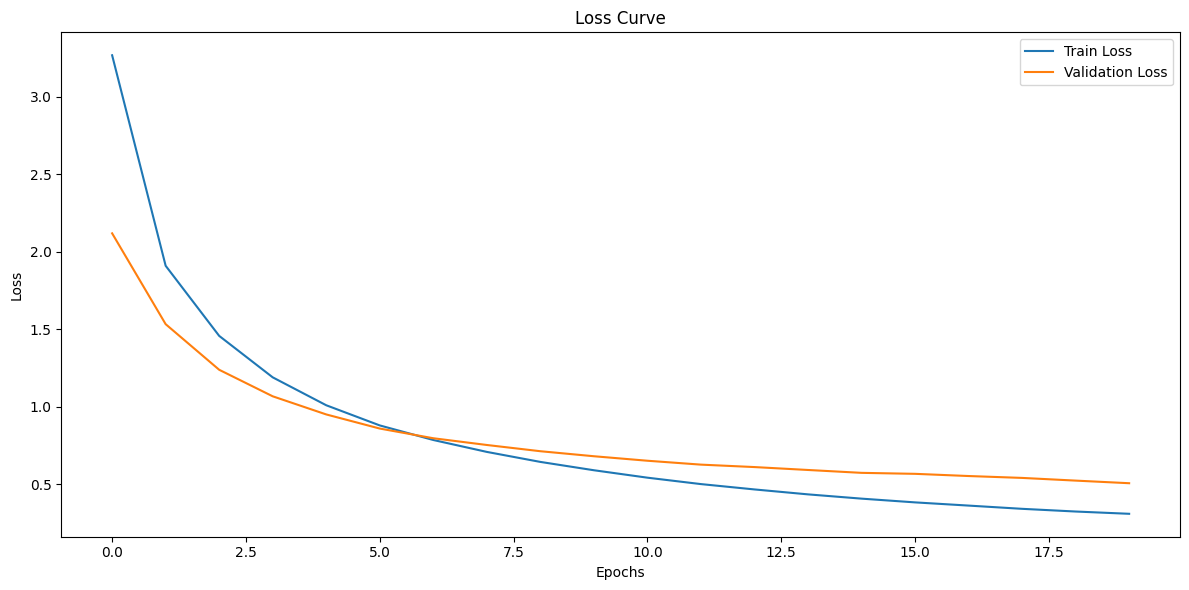

In [58]:
#train the model
epochs=20
batch_size= 16
history = train_model(eng_vocab_size, ger_vocab_size, eng_max_len, trainX, trainY_input, trainY_output, epochs, batch_size, build_model)

#plot the loss
plot_loss(history)  

* This cell loads the model that was saved by the checkpoint callback, which has the best validation loss. 

In [59]:
model = load_model('model.h1.10-10-24.keras') 

* This cell outputs the predicted sentences for the test dataset. 

In [60]:
predicted_sentences = pred_test(model, testX, ger_tokenizer, ger_max_len)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['DECODER_INPUT', 'decoder_state_h', 'decoder_state_c']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


* This cell outputs the original Target (German) sentences.

In [61]:
output_test_sentences = input_sentences(testY, ger_tokenizer)

* This cell outputs the English Sentences on which the predictions were made.

In [62]:
input_test_sentences = input_sentences(testX, eng_tokenizer)

* This cell prints out the BLEU score which helps dictate the generalisation of the model.

In [63]:
eval_bleu(output_test_sentences, predicted_sentences)

Corpus BLEU score: 0.0541


* The BLEU score for state of the art models is around **30-40%** and for a medium level model it is around 10-30%.

The BLEU score for this model is 5.4%  which is appreciable considering a few significant limitations and challenges faced such as:

***1) Limited computational resources*** (Even this less complex model took 9 hours to complete)
* The model is trained on a small dataset of 100000 sentence pairs (Which is less than half of the total number of pairs which is 277891).
* The model is trained for only 20 epochs which is a small number of epochs for training a model.
* The model is not deep enough to capture the complex relationships in the data.

***2) Lack of Attention Mechanism***
* The model does not have an attention mechanism which is essential for capturing the dependencies between words in the input and output sequences.
* The attention mechanism helps the model to focus on different parts of the input sequence while generating the output sequence.
* The absence of an attention mechanism can lead to poor performance in translating long sentences.

***3) Lack of Transformer Architecture***
* The model uses a simple Seq2Seq architecture which is not as effective as the Transformer architecture for machine translation tasks.
* The Transformer architecture uses self-attention mechanisms to capture the dependencies between words in the input and output sequences.
* The Transformer architecture is more efficient in capturing long-range dependencies and is widely used in state-of-the-art machine translation models.

***4) Lack of Pretrained Embeddings***
* The model does not use pretrained word embeddings which can help improve the performance of the model.
* Pretrained embeddings capture the semantic relationships between words and can help the model generalize better to unseen data.
* Using pretrained embeddings like Word2Vec, GloVe, or FastText can improve the performance of the model.

***5) Lack of Data Augmentation***
* The model does not use data augmentation techniques like back-translation, noise injection, or synonym replacement which can help improve the performance of the model.
* Data augmentation techniques can help the model generalize better to unseen data and improve the quality of the translations.
* Using data augmentation techniques can help the model learn more robust patterns in the data and improve the translation quality.

***6) Lack of Beam Search***
* The model uses a greedy search strategy to generate the output sequence which may not always produce the best translation.
* Using beam search can help the model explore multiple possible translations and choose the best one based on a scoring mechanism.
* Beam search can help the model generate more accurate translations and improve the quality of the output.

---


* The cell below prints out the English sentence, Original German sentence, and the Predicted German sentence for testing data.


In [68]:
for i in range(10,12):
    print("English Sentence: ", ' '.join(word for word in input_test_sentences[i].split() if word != "[unk]"))
    print("German Sentence: ", ' '.join(word for word in output_test_sentences[i].split() if word != "[unk]")) 
    print("Predicted German Sentence: ", predicted_sentences[i])
    print("\n")
    print("="*130)

English Sentence:  tell tom to relax
German Sentence:  [start] sag tom er soll sich erholen [end]
Predicted German Sentence:  verschwende sagen half einfach all doch für wie junge darf junge junge junge sorge wie sorge von


English Sentence:  ill take the train
German Sentence:  [start] ich nehme den zug [end]
Predicted German Sentence:  lässt hübsche während für wie darf sogar an jage immer wie auf mit an jage immer wie




* The inaccuracy of the predictions shown above can be attributed to the limitations mentioned above. 
* The debugging process I carried out (which is commented in the notebook) helped me understand the limitations and challenges faced during the training process. 
* It showed that the model doesn't predict the [end] token and that is why all predictions have words upto the maximum length of the sentence, insead of terminating the sequence generation when [end] token is predicted.

##### **STEP 6: Further Improvements To Consider**

* The model can be improved by incorporating the following techniques:
  * Using a Transformer architecture with self-attention mechanisms to capture the dependencies between words in the input and output sequences.
  * Using pretrained word embeddings like Word2Vec, GloVe, or FastText to capture the semantic relationships between words.
  * Using data augmentation techniques like back-translation, noise injection, or synonym replacement to improve the performance of the model.
  * Using beam search to generate more accurate translations and improve the quality of the output.
  * Using a larger dataset with more sentence pairs to train the model on a wider range of data.
  * Using a deeper model with more layers and units to capture the complex relationships in the data.
  * Using an attention mechanism to help the model focus on different parts of the input sequence while generating the output sequence.
  * Using a larger embedding size to capture more information about the words in the input and output sequences.
  * Using a larger batch size and more epochs to train the model for longer and improve the performance of the model.

***NOTE:*** All the above improvements are not included in the notebook due to the limitations of computational resources & time constraints.